In [1]:
import os
import traceback

from matplotlib import pyplot as plt
from utils.helpers import draw_pose, get_pose_from_file, convert_pose, get_pose, convert
from utils.train import train_svm_classifier
from utils.data import process_images, fill_empty_vector, flatten_dataset

from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2
import pandas as pd

%matplotlib inline

## Process images to the numpy format

In [2]:
def process(cartesian=False):
    
    features = []
    labels = []
    lines = []
    fig = plt.figure(figsize=(14,14))

    for x in os.walk(str(os.getcwd())+'/assets/images'):
        for d in x[1]:
            if d != 'test':
                print('processing images in {}'.format(d))
                for f in os.listdir(str(os.getcwd())+'/assets/images/'+d):
                    
                    try:
                        preds, img = get_pose_from_file(f, d)
                        
                        if preds['predictions']:
                            for i in range(len(preds['predictions'])):
                                pose_lines = preds['predictions'][i]['pose_lines']
                                body_parts = preds['predictions'][i]['body_parts']
                                coordinates = np.array([[d['x'], d['y']] for d in body_parts], dtype=np.float32)
                                p = convert_pose(coordinates, cartesian=cartesian)

                                if p != []:
                                    p = fill_empty_vector(p)
                                    features.append(p)
                                    labels.append(d)
                                    lines.append(pose_lines)

                    except Exception:
                        print("Something went wrong")
                        traceback.print_exc()
                        break

    return np.array(features), labels, np.array(lines)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

features, labels, lines = process(cartesian=False)

processing images in plank
processing images in warrior2
processing images in goddess
processing images in downdog


<Figure size 1008x1008 with 0 Axes>

## Augment data

In [4]:
# take the features and labels and add noise to them until each class reaches data_size
def augment_data(features, labels, data_size=15,noise_amount=0.03):
    print('\nAugmenting Data\n')
    orig_labels_count = len(labels)
    label_frequency = np.unique(labels, return_counts=True)
    
    while sum(label_frequency[1]) < data_size * len(label_frequency[0]):
        for i in range(orig_labels_count):
            if label_frequency[1][np.where(label_frequency[0] == labels[i])] < data_size:
                feature = features[i]
                new_data = np.zeros(feature.shape,dtype=np.float32)
                
                # add noise to each body part, making sure to add the same noise to corresponding joints
                for k, part in enumerate(feature):
                    noise = np.random.normal(0, noise_amount, 2)
                    new_0 = part[0] + noise[0]
                    new_1 = part[1] + noise[1]
                    new_data[k] = [new_0, new_1]

                features = np.concatenate((features, np.expand_dims(new_data,axis=0)))
                labels.append(labels[i])
            label_frequency = np.unique(labels, return_counts=True)

    return features, labels

data_size, noise = 100, 0.05
f_aug, l_aug = augment_data(features, labels, data_size=data_size, noise_amount=noise)


Augmenting Data



# PCA

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.DataFrame(columns=['Class','Nose_x','Nose_y',
    'Neck_x','Neck_y',
    'RShoulder_x','RShoulder_y',
    'RElbow_x','RElbow_y',
    'RWrist_x','RWrist_y',
    'LShoulder_x','LShoulder_y',
    'LElbow_x','LElbow_y',
    'LWrist_x','LWrist_y',
    'RHip_x','RHip_y',
    'RKnee_x','RKnee_y',
    'RAnkle_x','RAnkle_y',
    'LHip_x','LHip_y',
    'LKnee_x','LKnee_y',
    'LAnkle_x','LAnkle_y',
    'REye_x','REye_y',
    'LEye_x','LEye_y',
    'REar_x','REar_y',
    'LEar_x','LEar_y'])

df['Class'] = l_aug

for col in [name for name in df.columns if name != 'Class']:
    if '_x' in col:
        x = 0
    else:
        x = 1
    idx = (df.columns.get_loc(col)) % 19
    df[col] = f_aug[:,idx,x]
    
class_names = df['Class'].unique()
#df['Class'] = pd.factorize(df['Class'])[0] + 1

# separate features from target
feats = [name for name in df.columns if name != 'Class']

x = df.loc[:,feats].values
y = df.loc[:,['Class']].values

# standardize the features
x = StandardScaler().fit_transform(x)
# Select no. of components that keep 95% of the variability
pca = PCA(.95)

# get principal components
principal_components = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principal_components)
final_df = pd.concat([principal_df, df[['Class']]], axis=1)

## Plot the first two principal components so we can see how well the classes separate

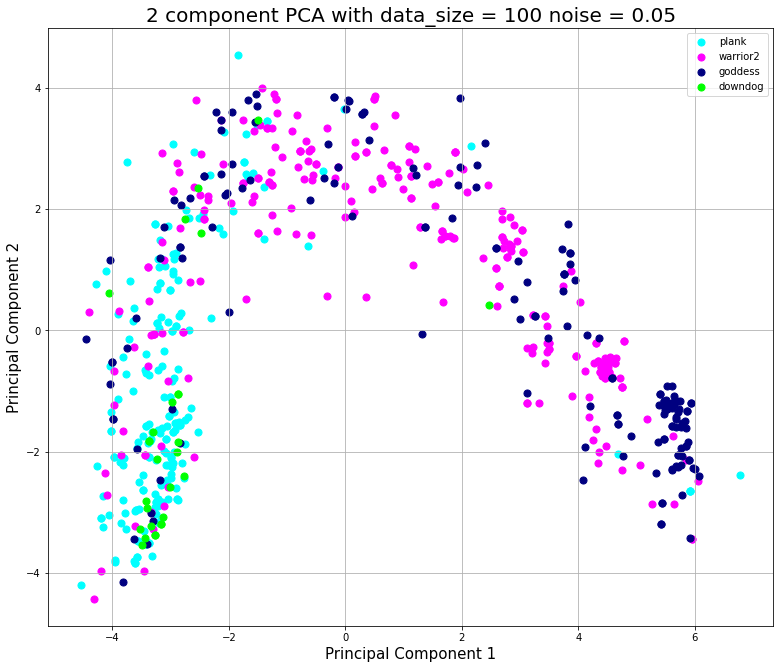

In [6]:
fig = plt.figure(figsize=(13,11))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(str('2 component PCA with data_size = {} noise = {}'.format(data_size, noise)), fontsize = 20)
targets = class_names
colors = ['aqua', 'magenta', 'navy', 'lime']

for target, color in zip(targets,colors):
    indicesToKeep = final_df['Class'] == target
    ax.scatter(final_df.loc[indicesToKeep, 0],
               final_df.loc[indicesToKeep, 1],
               c = color, s = 50)
    
ax.legend(targets)
ax.grid()

## Encode the labels so we can feed it into the SVM

In [7]:
def encode_labels(labels):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    name_map = {key:val for key,val in zip(integer_encoded,labels)}
    print(name_map)
    return np.array(integer_encoded), name_map

labels_encoded, name_map = encode_labels(l_aug)

{2: 'plank', 3: 'warrior2', 1: 'goddess', 0: 'downdog'}


## Get the ideal poses for each class

In [8]:
def get_ideal_pose(features, labels, name_map):
    ideal_poses = {}
    for lab, name in name_map.items():
        feature_list = np.array([feats for i, feats in enumerate(features) if labels[i]==lab])
        ideal_poses[name] = np.average(feature_list, axis=0)
        print(ideal_poses)
        
    return ideal_poses

ideal_poses = get_ideal_pose(f_aug, labels_encoded, name_map)


{'plank': array([[ 0.48969049, -0.89760055],
       [ 0.34492301, -1.11316589],
       [ 0.39043972, -0.90067416],
       [ 0.57383102,  0.78013289],
       [ 0.62898166,  0.61878584],
       [ 0.45425915, -0.43800826],
       [ 0.47256771, -0.10509426],
       [ 0.3939207 , -0.05754897],
       [ 0.28316956, -0.24134139],
       [ 0.22181405, -0.22434124],
       [ 0.16404767, -0.26609072],
       [ 0.09949093, -0.14781154],
       [ 0.06510347, -0.13401823],
       [ 0.05770161, -0.07834131],
       [ 0.01831374, -0.05888261],
       [ 0.01647535, -0.04559282],
       [ 0.01369217, -0.04424516],
       [ 0.01119456, -0.02814773],
       [ 0.        ,  0.        ]])}
{'plank': array([[ 0.48969049, -0.89760055],
       [ 0.34492301, -1.11316589],
       [ 0.39043972, -0.90067416],
       [ 0.57383102,  0.78013289],
       [ 0.62898166,  0.61878584],
       [ 0.45425915, -0.43800826],
       [ 0.47256771, -0.10509426],
       [ 0.3939207 , -0.05754897],
       [ 0.28316956, -0.24134139]

## Training SVM

In [9]:
features_flat = flatten_dataset(f_aug)
classifier, svm = train_svm_classifier(features_flat, labels_encoded,'assets/classifier.pkl')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    1.0s finished


## Test the SVM

The prediction is warrior2 with confidence 79.51281342308636 %
The real pose is  warrior_pose4


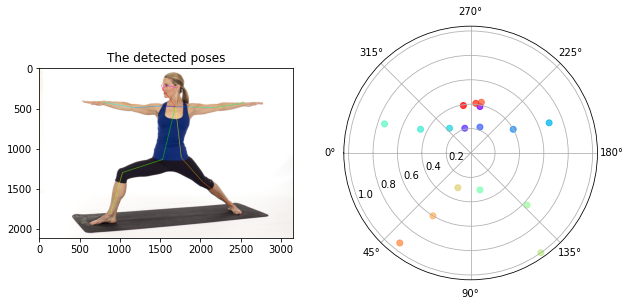

The prediction is goddess with confidence 91.4565887526646 %
The real pose is  godess_pose0


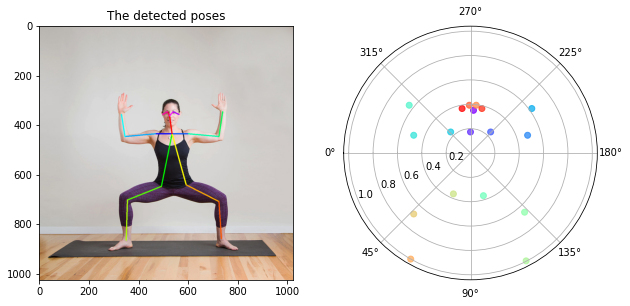

The prediction is warrior2 with confidence 73.88876527567983 %
The real pose is  godess_pose7


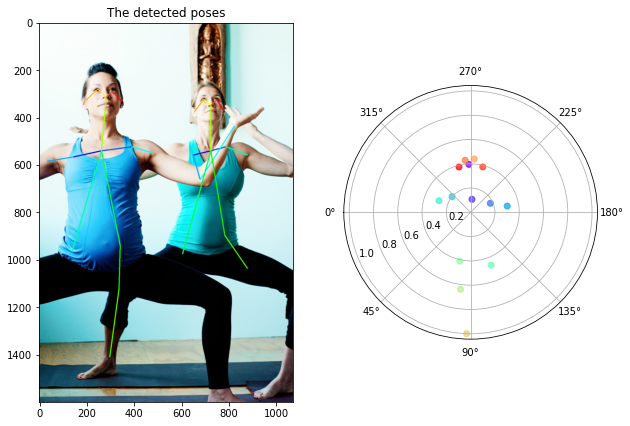

The prediction is goddess with confidence 73.3059998892742 %
The real pose is  godess_pose6


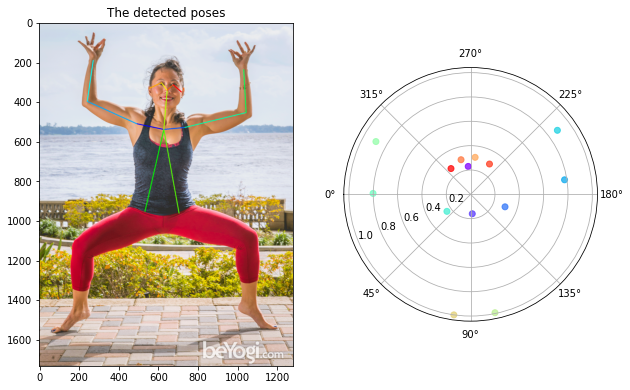

The prediction is plank with confidence 64.98928590465533 %
The real pose is  plank2


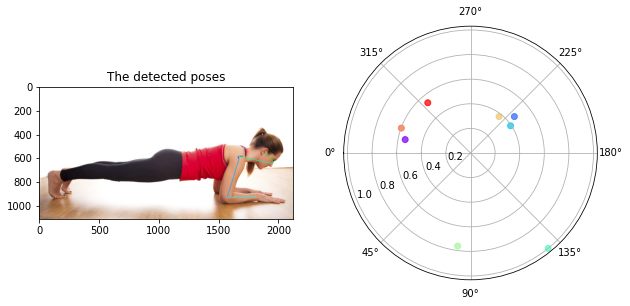

The prediction is plank with confidence 60.83471951013997 %
The real pose is  plank6


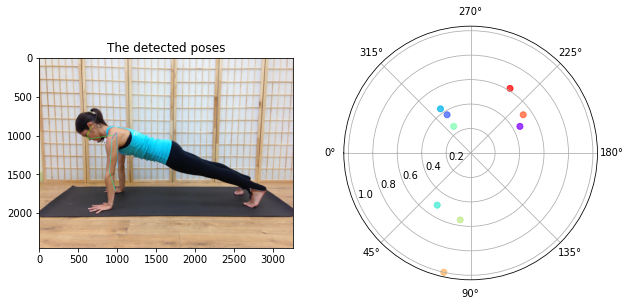

IndexError: list index out of range

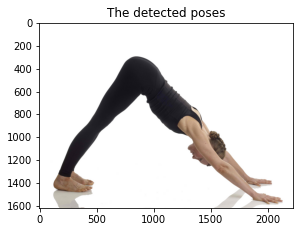

In [10]:
import matplotlib.cm as cm

for img in os.listdir(str(os.getcwd())+'/assets/images/test'):
    fig = plt.figure(figsize=(10,15))
    # visualize the pose
    plt.subplot(1,2,1)
    
    preds, frame = get_pose_from_file(img,'test')
    bgr = np.array(cv2.imread('./assets/images/test/'+img))
    pose_img = bgr[..., ::-1]
    draw_pose(preds, bgr)
    plt.imshow(pose_img)
    plt.title("The detected poses")
    
    # make predictions
    body_parts = preds['predictions'][0]['body_parts']
    coordinates = np.array([[d['x'], d['y']] for d in body_parts], dtype=np.float32)
    pose = np.array(convert_pose(coordinates, cartesian=False))
    x = flatten_dataset(np.expand_dims(fill_empty_vector(np.squeeze(pose)), axis=0))
    p = classifier.predict(x)
    prediction = name_map[p[0]]
    confidence = classifier.predict_proba(x)
    print('The prediction is {} with confidence {} %'.format(prediction, 100 * confidence[0][p[0]]))
    print('The real pose is ', img.split('.')[0])
    
    # visualize the polar plot
    ax = plt.subplot(1, 2, 2, projection='polar')
    ax.set_theta_zero_location("W")
    colors = cm.rainbow(np.linspace(0, 1, len(pose[:,0])))
    c = plt.scatter(pose[:, 1], pose[:, 0], cmap='hsv', alpha=0.75, c=colors)
    plt.show()

In [11]:
import pickle

def live_inference(rate=5):
    """
    Run live inference using the webcam. Plot polar coordinates of
    the estimated pose and print prediction to terminal.
    """

    # if there is not a classifier model, train the model then use the saved file
    if not os.path.exists('assets/classifier.pkl'):
        f, l, _ = process_images()
        f, l = augment_data(f, l, data_size=500)  # noqa (ambiguous variable name)
        f = flatten_dataset(f)
        l, name_map = encode_labels(l)

        _, _ = train_svm_classifier(f, l, 'assets/classifier.pkl')

    with open('assets/classifier.pkl', 'rb') as fil:
        classifier = pickle.load(fil)

    with open('assets/classes.pkl', 'rb') as fil:
        name_map = pickle.load(fil)

    fig = plt.figure()
    fig.show()
    ax = fig.add_subplot(111, projection='polar')

    # Run the pose detection using the webcam
    cap = cv2.VideoCapture(0)
    cap.set(3, 656)
    cap.set(4, 368)

    if cap.isOpened():
        is_capturing, frame = cap.read()
    else:
        is_capturing = False

    current_prediction = 'shavasana'
    current_frame = 0
    while is_capturing:
        try:
            is_capturing, frame = cap.read()
            cv2.imwrite('assets/image.jpg', frame)

            if current_frame % rate == 0 or current_frame == 0:
                preds, img = get_pose()

                # make sure that we have enough vectors to accurately classify something
                if preds['predictions'] != [] and len(preds['predictions'][0]['pose_lines']) > 12:
                    coordinates = np.array([[d['x'], d['y']] for d in preds['predictions'][0]['body_parts']], dtype=np.float32)
                    frame = convert(coordinates)
                    missing_vals = 19 - frame.shape[0]
                    frame = np.concatenate([frame, np.zeros([missing_vals, 2])])
                    nx, ny = frame.shape
                    reshaped_frame = frame.reshape((1, nx*ny))

                    # make predictions
                    prediction = classifier.predict(reshaped_frame)
                    confidence = classifier.predict_proba(reshaped_frame)
                    current_prediction = name_map[prediction[0]]
                    print("{}%  confident that the pose is {}".format(confidence[0][prediction[0]], current_prediction))

                    # check cosine similarity to the ideal pose
                    # ideal = np.array(ideal_poses[current_prediction])
                    # closeness = cosine_similarity(ideal, reshaped_frame)
                    # print('SIMILARITY TO IDEAL {}\n{}'.format(current_prediction,closeness))

                    # draw frame with new predictions
                    overlaid_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    draw_pose(preds, overlaid_img)
                    cv2.imshow('Frame', overlaid_img)

                    # plot the polar chart
                    ax.cla()
                    ax.set_theta_zero_location("W")
                    colors = cm.rainbow(np.linspace(0, 1, len(frame[:, 0])))
                    ax.scatter(frame[:, 1], frame[:, 0], cmap='hsv', alpha=0.75, c=colors)
                    fig.canvas.draw()

                else:
                    cv2.imshow('Frame', frame)

            else:
                draw_pose(preds, frame)
                cv2.imshow('Frame', frame)

            current_frame += 1

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

        except KeyboardInterrupt:
            cap.release()
            cv2.destroyAllWindows()

<ipython-input-11-65b6cbfa3329>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.8172596355565848%  confident that the pose is side_lunge_right
0.8329257199937546%  confident that the pose is side_lunge_right
0.2946444790751899%  confident that the pose is t_pose
0.25322819622468734%  confident that the pose is t_pose
0.25484403344405293%  confident that the pose is t_pose
0.28507511120399226%  confident that the pose is t_pose
0.31252736153737315%  confident that the pose is t_pose


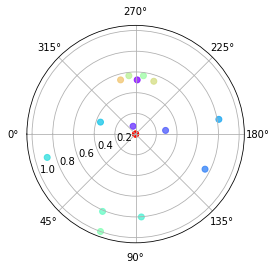

In [12]:
live_inference()